<h1>SIT307 Group Assignment 1 notebook</h1>

<h3>Group 3</h3>
<p>By:<br>
    Aaron Norwood,218330434<br>
    Joshua Anthony, 219466473<br>
    Roger Middenway, 217602784<br>
    David Adams, 216110104<br>
    Linden Hutchinson, 218384326<br>
    Dale Orders, 219106283

# Imported libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
import plotly.express as px
%matplotlib inline

<h3> Read in the data, store if dataframe

In [2]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

<h4>Tidying

In [3]:
##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

# print(len(df[df['gender'] == 'other']))
## drop the one row that has "other" gender to keep things simple
df.drop(index=df[df['gender'] == 'other'].index, inplace=True)

# replace gender with binary values
df['gender'] = df['gender'].str.lower().map({'male': 1, 'female': 0})

# replace marital status with binary values
df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

## round off age
df['age'] = df['age'].apply(lambda x : round(x))

# cap BMI outliers to a maximum of 60 
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)

<h4>Imputing

In [4]:
m_df = df[df['gender'] == 1]
f_df = df[df['gender'] == 0]

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 1:
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]

<h4>Binning

In [5]:
# implement age bins
df['age_bin'] = pd.qcut(df['age'], q = 10, precision=1)

# implement glucose bins
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)

# implement bmi bins
df['bmi_bin'] = pd.qcut(df['bmi'], q=10, precision=1)

In [6]:
df.drop(['id'], axis=1, inplace=True)

<h4>Mapping

In [7]:
def add_dummy(target_df, origin_df, col):
    abbrev = col[:2] + '_'
    for cat in origin_df[col].value_counts().index.tolist()[1:]:
        target_df[abbrev + str(cat)] = origin_df[col] == cat
        target_df[abbrev + str(cat)] = target_df[abbrev + str(cat)].map({False: 0, True: 1})


In [8]:
df_dummies = pd.DataFrame(index=df.index)

add_dummy(df_dummies, df, 'work_type')
add_dummy(df_dummies, df, 'smoking_status')
add_dummy(df_dummies, df, 'age_bin')
add_dummy(df_dummies, df, 'avg_glucose_level_bin')
add_dummy(df_dummies, df, 'bmi_bin')

In [9]:
to_add = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'stroke']
df_dummies[to_add] = df[to_add]

In [10]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot

# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

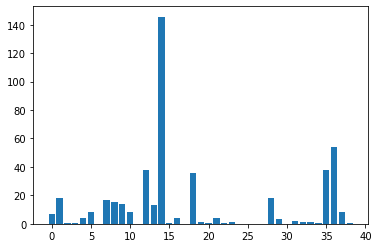

In [14]:
X = df_dummies.drop(['stroke'], axis=1)
y = df_dummies['stroke']
X = X.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

# what are scores for the features
score_list = {}

for i in range(len(fs.scores_)):
    score_list.update({df_dummies.columns[i]:fs.scores_[i]})

# # plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()


In [13]:
import operator

def get_dict_sorted_by_values(dict):
    sorted_tuples = sorted(dict.items(), key=operator.itemgetter(1))
    return {k: v for k, v in sorted_tuples}

sorted_scores = get_dict_sorted_by_values(score_list)
for feat, score in sorted_scores.items():
    print(f"'{feat}'",end=",\n")


'av_(65.8, 73.8]',
'bm_(34.2, 38.6]',
'bm_(28.2, 29.9]',
'sm_smokes',
'bm_(38.6, 59.7]',
'bm_(24.7, 26.6]',
'ag_(51.0, 57.0]',
'av_(73.8, 80.0]',
'av_(55.0, 65.8]',
'av_(91.9, 98.9]',
'ag_(45.0, 51.0]',
'gender',
'wo_govt-job',
'wo_never-worked',
'residence_type',
'av_(85.6, 91.9]',
'av_(124.1, 192.2]',
'bm_(31.8, 34.2]',
'bm_(19.8, 22.6]',
'bm_(26.6, 28.2]',
'bm_(22.6, 24.7]',
'av_(108.5, 124.1]',
'sm_unknown',
'av_(80.0, 85.6]',
'wo_self-employed',
'sm_formerly-smoked',
'ag_(38.0, 45.0]',
'ever_married',
'ag_(11.0, 20.0]',
'ag_(30.0, 38.0]',
'ag_(-0.1, 11.0]',
'ag_(20.0, 30.0]',
'bm_(29.9, 31.8]',
'wo_children',
'av_(192.2, 271.7]',
'hypertension',
'ag_(65.0, 75.0]',
'heart_disease',
'ag_(75.0, 82.0]',


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score
from IPython.display import clear_output

In [ ]:
def get_svc(class_weight=None, kernel="rbf", gamma='scale', shrinking=True, probability=False):
    return SVC(class_weight=class_weight, kernel=kernel, gamma=gamma,shrinking=shrinking,probability=False)

def get_cv_scores(X, y, model, n_splits=5,n_repeats=10, scoring=None):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    return cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)

def run_model(model, test_split=0.33):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=82)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(model, X_test, y_test)
    print(classification_report(y_test, y_pred))

In [ ]:


model = get_svc()
scores = get_cv_scores(X, y, model)
print(scores.mean())

run_model(model, X_train)